In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "128"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

import matplotlib as mpl
mpl.rc('image', cmap='coolwarm')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os

In [3]:
os.environ['data'] = '/pscratch/sd/j/jianyao/data_lensing/simulations/'

In [4]:
from os.path import join as opj

In [5]:
import healpy as hp
import numpy as np

In [6]:
# Finally, synfast will build a realization of the lensed maps for you from scratch
from lenspyx import synfast
from lenspyx.utils import camb_clfile

In [40]:
import plancklens
from plancklens.filt import filt_simple, filt_util
from plancklens import utils
from plancklens import qest, qecl, qresp
from plancklens import nhl
from plancklens.n1 import n1
from plancklens.sims import planck2018_sims, phas, maps, utils as maps_utils

In [8]:
import pysm3 
import pysm3.units as u

In [9]:
from plancklens.utils import clhash, hash_check

In [11]:
# lmax_len = 3000 # desired lmax of the lensed field.
# dlmax = 1024  # lmax of the unlensed fields is lmax + dlmax.  (some buffer is required for accurate lensing at lmax)
# epsilon = 1e-6 # target accuracy of the output maps (execution time has a fairly weak dependence on this)
# lmax_unl, mmax_unl = lmax_len + dlmax, lmax_len + dlmax
# NSIDE = 2048 

In [10]:
cls_path = '/global/homes/j/jianyao/non_gau_lensing/theory/cls/'

# simulation class

In [26]:
class cmb_len(object):

    def __init__(self, add_foreground = False):
        
        if add_foreground:
            self.add_foreground = add_foreground
        
        else:
            self.add_foreground = 'no_fore'
        
        self.dirs = os.environ["data"] + 'cmb_plus_%s'%add_foreground
        
    def hashdict(self):
        return {'sim_lib': 'ffp10 lensed scalar cmb inputs, freq 0'}

    # @staticmethod
    def get_sim_tlm(self, idx):
        
        return hp.read_alm(opj(self.dirs, 'lensed_scl_cmb_plus_%s_alm_mc_%04d.fits'%(self.add_foreground, idx)), hdu=1)
    
    # @staticmethod
    def get_sim_elm(self, idx):

        return hp.read_alm(opj(self.dirs, 'lensed_scl_cmb_plus_%s_alm_mc_%04d.fits'%(self.add_foreground, idx)), hdu=2)

    # @staticmethod
    def get_sim_blm(self, idx):

        return hp.read_alm(opj(self.dirs, 'lensed_scl_cmb_plus_%s_alm_mc_%04d.fits'%(self.add_foreground, idx)), hdu=3)
    
    
class cmb_noise(object):
    r"""CMB simulation library combining a lensed CMB library and a transfer function.

        Args:
            sims_cmb_len: lensed CMB library (e.g. *plancklens.sims.planck2018_sims.cmb_len_ffp10*)
            cl_transf: CMB temperature transfer function
            nside: healpy resolution of the maps. Defaults to 2048.
            lib_dir(optional): hash checks will be cached, as well as possibly other things for subclasses.
            cl_transf_P: CMB pol transfer function (if different from cl_transf)

    """
    def __init__(self, sims_cmb_len, cl_transf, nlev_t, nlev_p, nside=2048, cl_transf_P=None, lib_dir=None):
        if cl_transf_P is None:
            cl_transf_P = np.copy(cl_transf)

        self.sims_cmb_len = sims_cmb_len
        self.cl_transf_T = cl_transf
        self.cl_transf_P = cl_transf_P
        self.nside = nside
        self.nlev_t = nlev_t
        self.nlev_p = nlev_p
        self.vamin = np.sqrt(hp.nside2pixarea(self.nside, degrees=True)) * 60

        if lib_dir is not None:
            fn_hash = os.path.join(lib_dir, 'sim_hash.pk')
            if mpi.rank == 0 and not os.path.exists(fn_hash):
                pk.dump(self.hashdict(), open(fn_hash, 'wb'), protocol=2)
            mpi.barrier()
            hash_check(self.hashdict(), pk.load(open(fn_hash, 'rb')), fn=fn_hash)

    def hashdict(self):
        ret = {'sims_cmb_len':self.sims_cmb_len.hashdict(),'nside':self.nside,'cl_transf':clhash(self.cl_transf_T)}
        if not (np.all(self.cl_transf_P == self.cl_transf_T)):
            ret['cl_transf_P'] = clhash(self.cl_transf_P)
        return ret

    def get_sim_tmap(self,idx):
        """Returns temperature healpy map for a simulation

            Args:
                idx: simulation index

            Returns:
                healpy map

        """
        tmap = self.sims_cmb_len.get_sim_tlm(idx)
        hp.almxfl(tmap,self.cl_transf_T,inplace=True)
        tmap = hp.alm2map(tmap,self.nside)
        return tmap + self.get_sim_tnoise(idx)

    def get_sim_pmap(self,idx):
        """Returns polarization healpy maps for a simulation

            Args:
                idx: simulation index

            Returns:
                Q and U healpy maps

        """
        elm = self.sims_cmb_len.get_sim_elm(idx)
        hp.almxfl(elm,self.cl_transf_P,inplace=True)
        blm = self.sims_cmb_len.get_sim_blm(idx)
        hp.almxfl(blm, self.cl_transf_P, inplace=True)
        Q,U = hp.alm2map_spin([elm,blm], self.nside, 2,hp.Alm.getlmax(elm.size))
        del elm,blm
        return Q + self.get_sim_qnoise(idx),U + self.get_sim_unoise(idx)

    def get_sim_tnoise(self,idx):
        
        return self.nlev_t / self.vamin * np.load(opj(os.environ["data"],'noise/noise_1uK_amin_map_mc_%04d.npy'%idx))[0] # one frequency for now 11.15

    def get_sim_qnoise(self, idx):
        
        return self.nlev_p / self.vamin * np.load(opj(os.environ["data"],'noise/noise_1uK_amin_map_mc_%04d.npy'%idx))[1]

    def get_sim_unoise(self, idx):
        
        return self.nlev_p / self.vamin * np.load(opj(os.environ["data"],'noise/noise_1uK_amin_map_mc_%04d.npy'%idx))[2]

In [24]:
def gen_noise_map(nlep, nside, N):
    
    '''
    nlep: noise level for each frequency band
    '''
    depth_p =np.array(nlep)
    depth_i = depth_p/np.sqrt(2)
    pix_amin2 = 4. * np.pi / float(hp.nside2npix(nside)) * (180. * 60. / np.pi) ** 2
    """sigma_pix_I/P is std of noise per pixel. It is an array of length
    equal to the number of input maps."""
    sigma_pix_I = np.sqrt(depth_i ** 2 / pix_amin2)
    sigma_pix_P = np.sqrt(depth_p ** 2 / pix_amin2)
    npix = hp.nside2npix(nside)
    
    for i in range(N):
        noise = np.random.randn(len(depth_i), 3, npix) # first dimension is the index of frequency band
        noise[:, 0, :] *= sigma_pix_I[:, None]
        noise[:, 1, :] *= sigma_pix_P[:, None]
        noise[:, 2, :] *= sigma_pix_P[:, None]
        
        np.save(opj(os.environ["data"],'noise/noise_1uK_amin_map_mc_%04d.npy'%i), noise[0]) # one frequency for now 11.15

def gen_cmb_len_alm(nside, N, fwhm = None, add_foreground = False):
    
    '''
    return one realization of unlensed CMB map and lensed CMB map with the beam applied
    '''
    
    cl_unl = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
    geom_info = ('healpix', {'nside':nside}) # Geometry parametrized as above, this is the default
    
    for i in range(N):
        maps = synfast(cl_unl, lmax=lmax_unl, verbose=1, geometry=geom_info, alm = True)
        # Generations of the unlensed alms will include all correlations as given in the cl_unl dictionary
        # Feed-in alm=True to return the unlensed alm as well

        cmb_len = np.row_stack((maps[0]['T'], maps[0]['QU']))
        # cmb_len = hp.smoothing(cmb_len, fwhm = fwhm)
        # cmb_unl = hp.alm2map(maps[1][0], nside = NSIDE, fwhm = fwhm)
        
        if add_foreground == 'd0':
            sky = pysm3.Sky(nside=nside, preset_strings=["d0"])
            map_100GHz = sky.get_emission(100 * u.GHz)
            map_100GHz = map_100GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(100*u.GHz))
            
            map_100GHz = map_100GHz.value + cmb_len
            alms = hp.map2alm(map_100GHz)
            
        elif add_foreground == 'forse3':
            
            map_100GHz = np.zeros((3, 12*nside**2))
            
            forse_Q = hp.read_map('/pscratch/sd/j/jianyao/data_lensing/processed_dust_maps/forse_dust_Q_353GHz_3amin_nside4096_uK_CMB.fits')
            forse_U = hp.read_map('/pscratch/sd/j/jianyao/data_lensing/processed_dust_maps/forse_dust_U_353GHz_3amin_nside4096_uK_CMB.fits')
            
            map_100GHz[1] = pysm3.apply_smoothing_and_coord_transform(forse_Q, output_nside=nside)
            map_100GHz[2] = pysm3.apply_smoothing_and_coord_transform(forse_U, output_nside=nside)
            
            map_100GHz = map_100GHz + cmb_len
            alms = hp.map2alm(map_100GHz)         
            
        elif add_foreground is False:
            
            add_foreground = 'no_fore'
            alms = hp.map2alm(cmb_len)        
    
        dirs = os.environ["data"] + 'cmb_plus_%s'%add_foreground
        if not os.path.exists(dirs):
            os.makedirs(dirs)

        hp.write_alm(opj(dirs, 'lensed_scl_cmb_plus_%s_alm_mc_%04d.fits'%(add_foreground, i)), alms)

## generating maps

In [128]:
# gen_noise_map(nlep=[1.0,], nside=1024, N = 1)
# gen_cmb_len_alm(nside=1024, N = 1, add_foreground='d0')
gen_cmb_len_alm(nside=1024, N = 1, add_foreground='forse3')

  cl matrix        :  [0:00:00.026402] (0.5%)  
  phases generation:  [0:00:01.015234] (21.1%)  
  alms from phases :  [0:00:01.254764] (26.0%)  
  alm2lenmap       :  [0:00:02.460395] (51.0%)  
  Total            :  [0:00:04.821393] d:h:m:s:mus


In [129]:
gen_cmb_len_alm(nside=1024, N = 1, add_foreground=False)

  cl matrix        :  [0:00:00.031109] (0.7%)  
  phases generation:  [0:00:01.048289] (22.6%)  
  alms from phases :  [0:00:01.255560] (27.1%)  
  alm2lenmap       :  [0:00:02.249424] (48.6%)  
  Total            :  [0:00:04.628330] d:h:m:s:mus


# apply plancklens

In [33]:
# os.environ['PLENS'] = '/pscratch/sd/j/jianyao/data_lensing/only_noise'
os.environ['PLENS'] = '/pscratch/sd/j/jianyao/data_lensing/c_n_forse3'
TEMP =  os.path.join(os.environ['PLENS'], 'temp')

In [14]:
#--- definition of simulation and inverse-variance filtered simulation libraries:
lmax_ivf = 2048
lmin_ivf = 100  # We will use in the QE only CMB modes between lmin_ivf and lmax_ivf
lmax_qlm = 2048 # We will calculate lensing estimates until multipole lmax_qlm.; 4096
nside = 1024 # Healpix resolution of the data and sims.; 2048


nlev_t = 2.16 # Filtering noise level in temperature (here also used for the noise simulations generation).
nlev_p = 2.16 # Filtering noise level in polarization (here also used for the noise simulations generation).
nsims = 300  # Total number of simulations to consider.

transf = hp.gauss_beam(4. / 60. / 180. * np.pi, lmax=lmax_ivf) * hp.pixwin(nside)[:lmax_ivf + 1]
#: CMB transfer function. Here a 5' Gaussian beam and healpix pixel window function.

In [15]:
cl_unl = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
cl_len = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))
#: Fiducial unlensed and lensed power spectra used for the analysis.

cl_weight = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))
cl_weight['bb'] *= 0.
#: CMB spectra entering the QE weights (the spectra multplying the inverse-variance filtered maps in the QE legs) # to get the wiener filtered maps?

In [34]:
sims = cmb_noise(cmb_len(add_foreground='forse3'), transf, nlev_t, nlev_p, nside)

In [35]:
ftl = utils.cli(cl_len['tt'][:lmax_ivf + 1] + (nlev_t / 60. / 180. * np.pi / transf) ** 2)
fel = utils.cli(cl_len['ee'][:lmax_ivf + 1] + (nlev_p / 60. / 180. * np.pi / transf) ** 2)
fbl = utils.cli(cl_len['bb'][:lmax_ivf + 1] + (nlev_p / 60. / 180. * np.pi / transf) ** 2)
ftl[:lmin_ivf] *= 0.
fel[:lmin_ivf] *= 0.
fbl[:lmin_ivf] *= 0.
#: Inverse CMB co-variance in T, E and B (neglecting TE coupling).

ivfs = filt_simple.library_fullsky_sepTP(os.path.join(TEMP, 'ivfs'), sims, nside, transf, cl_len, ftl, fel, fbl, cache=True)
#: Inverse-variance filtering instance. Here a trivial isotropic inverse variance weighting.

In [36]:
#---- QE libraries instances. For the MCN0, RDN0, MC-correction etc calculation, we need in general three of them,
# which we called qlms_dd, qlms_ds, qlms_ss.
# qlms_dd is the QE library which builds a lensing estimate with the same simulation on both legs
# qlms_ds is the QE library which builds a lensing estimate with a simulation on one leg and the data on the second.
# qlms_ss is the QE library which builds a lensing estimate with a simulation on one leg and another on the second.

# Shuffling dictionary used for qlms_ss. This remaps idx -> idx + 1 by blocks of 60 up to 300:
ss_dict = { k : v for k, v in zip( np.concatenate( [ range(i*60, (i+1)*60) for i in range(0,5) ] ),
                    np.concatenate( [ np.roll( range(i*60, (i+1)*60), -1 ) for i in range(0,5) ] ) ) }
# Shuffling dictionary used for qlms_ds. This remap all sim. indices to the data maps:
ds_dict = { k : -1 for k in range(300)}

ivfs_d = filt_util.library_shuffle(ivfs, ds_dict)
#: This is a filtering instance always returning the data map.
ivfs_s = filt_util.library_shuffle(ivfs, ss_dict)
#: This is a filtering instance shuffling simulation indices according to 'ss_dict'.


qlms_dd = qest.library_sepTP(os.path.join(TEMP, 'qlms_dd'), ivfs, ivfs,   cl_len['te'], nside, lmax_qlm=lmax_qlm)
# qlms_ds = qest.library_sepTP(os.path.join(TEMP, 'qlms_ds'), ivfs, ivfs_d, cl_len['te'], nside, lmax_qlm=lmax_qlm)
# qlms_ss = qest.library_sepTP(os.path.join(TEMP, 'qlms_ss'), ivfs, ivfs_s, cl_len['te'], nside, lmax_qlm=lmax_qlm)

Caching sky fractions...


## QE

In [52]:
#---- QE spectra libraries instances:
# This takes power spectra of the QE maps from the QE libraries, after subtracting a mean-field.
# Only qcls_dd needs a mean-field subtraction.

# mc_sims_bias = np.arange(60) #: The mean-field will be calculated from these simulations.
# mc_sims_var  = np.arange(60, 300) #: The covariance matrix will be calculated from these simulations

mc_sims_mf_dd = np.array([])
mc_sims_mf_ds = np.array([])
mc_sims_mf_ss = np.array([]) #:By construction, only qcls_dd needs a mean-field subtraction.

qcls_dd = qecl.library(os.path.join(TEMP, 'qcls_dd'), qlms_dd, qlms_dd, mc_sims_mf_dd)
# qcls_ds = qecl.library(os.path.join(TEMP, 'qcls_ds'), qlms_ds, qlms_ds, mc_sims_mf_ds)
# qcls_ss = qecl.library(os.path.join(TEMP, 'qcls_ss'), qlms_ss, qlms_ss, mc_sims_mf_ss)


Caching sky fractions...


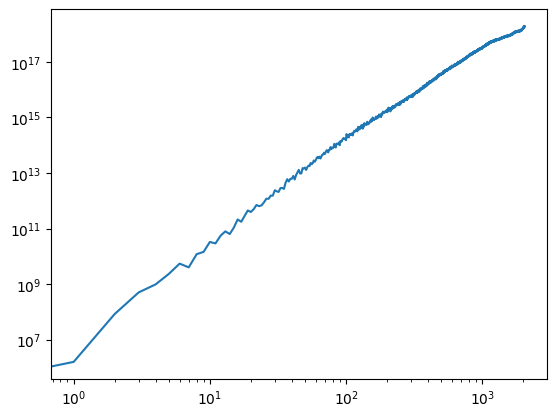

In [87]:
plt.loglog(qcls_dd.get_sim_qcl('ptt', 0))

## bias

In [37]:
from plancklens import nhl
from plancklens.n1 import n1

In [38]:
#---- semi-analytical Gaussian lensing bias library:
nhl_dd = nhl.nhl_lib_simple(os.path.join(TEMP, 'nhl_dd'), ivfs, cl_weight, lmax_qlm)

#---- N1 lensing bias library:
libdir_n1_dd = os.path.join(TEMP, 'n1_test')
n1_dd = n1.library_n1(libdir_n1_dd,cl_len['tt'],cl_len['te'],cl_len['ee'])

In [41]:
#---- QE response calculation library:
qresp_dd = qresp.resp_lib_simple(os.path.join(TEMP, 'qresp'), lmax_ivf, cl_weight, cl_len,
                                 {'t': ivfs.get_ftl(), 'e':ivfs.get_fel(), 'b':ivfs.get_fbl()}, lmax_qlm)

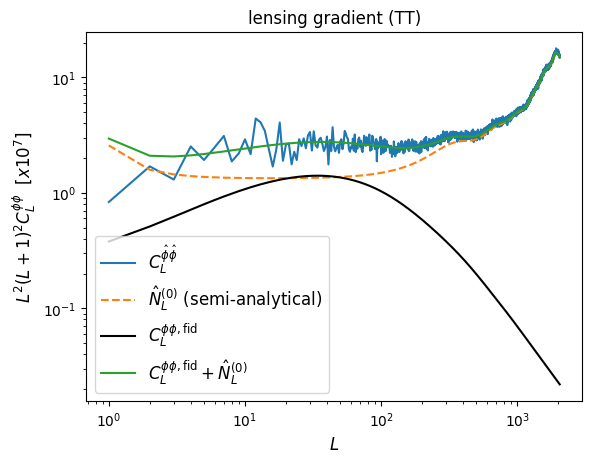

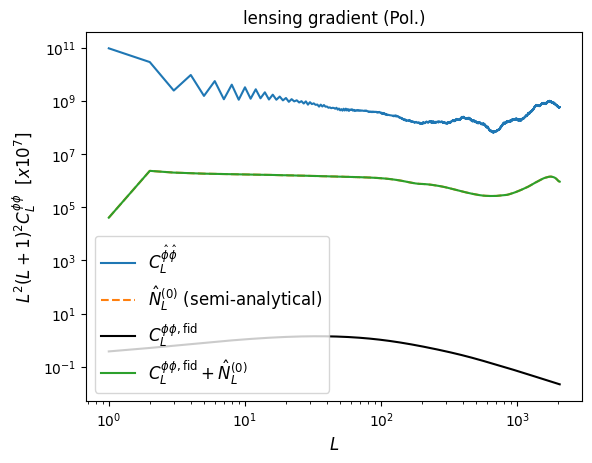

In [43]:
for qe_key in ['ptt','p_p']:
#     # This loads the estimate calculated in the previous cell:
    qlm = qlms_dd.get_sim_qlm(qe_key, 0)

    # Lensing response according to the fiducial cosmology:
    qresp_dat = qresp_dd.get_response(qe_key, 'p')
 
    # Estimator normalization is the inverse response:
    qnorm = utils.cli(qresp_dat)
    
#     # Semi-analytical realization-dependent Gaussian noise bias (of the unnormalized estimator):
    nhl = nhl_dd.get_sim_nhl(0, qe_key, qe_key)

    # and we plot the normalized resulting spectra:
    w = lambda ell : ell ** 2 * (ell + 1.) ** 2 * 0.5 / np.pi * 1e7
    ell = np.arange(2 if qe_key[0] == 'x' else 1, 2048)
    
    plt.figure()
    plt.title('lensing gradient (TT)' if qe_key[-1] == 't' else 'lensing gradient (Pol.)')
    label=r'$C_L^{\hat \phi \hat \phi}$' if qe_key[0] == 'p' else r'$C_L^{\hat \omega \hat \omega}$'
    plt.loglog(ell, hp.alm2cl(qlm)[ell] * qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell), label=label)
    plt.loglog(ell, nhl[ell] * qnorm[ell] ** 2 * w(ell), '--', label=r'$\hat N_L^{(0)}$ (semi-analytical)')
    plt.loglog(ell, cl_unl['pp'][ell] *  w(ell), c='k', label=r'$C_L^{\phi\phi, \rm fid}$')
    if  qe_key[0] == 'p':
        plt.loglog(ell, (cl_unl['pp'][ell] + nhl[ell] * qnorm[ell] ** 2) *  w(ell), label=r'$C_L^{\phi\phi, \rm fid} + \hat N_L^{(0)}$ ')
    plt.xlabel('$L$', fontsize=12)
    plt.ylabel('$L^2 (L + 1)^2 C_L^{\phi\phi}$  [$x10^7$]', fontsize=12)
    plt.legend(fontsize=12, loc='lower left')